In [203]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import tqdm as tqdm
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
import deepchem as dc

In [307]:
small_dataset = pd.read_csv('Small_training_set.txt')
large_dataset = pd.read_csv('Large_dataset.csv')


# Calculate descriptors

In [276]:
#Load descriptors 
def mol_lib_load(input_data):
    training_set = pd.read_csv('{}'.format(input_data))
    #print(training_set['SMILES'])
    mol_lib = []
    for SMILES in training_set['SMILES']:
        mol = Chem.MolFromSmiles('{}'.format(SMILES))
        mol_lib.append(mol)

    return mol_lib

def descriptor_calc(mol):
    mwt = Descriptors.MolWt(mol)
    mol_logP = Descriptors.MolLogP(mol)
    HBD = Descriptors.NumHDonors(mol)
    HBA = Descriptors.NumHAcceptors(mol)
    Aromatic_rings = Descriptors.NumAromaticRings(mol)
    Rot_bonds = Descriptors.NumRotatableBonds(mol)
    TPSA = Descriptors.TPSA(mol)
    Het_atoms = Descriptors.NumHeteroatoms(mol)
    arom_atm = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())]
    a = arom_atm.count(True)
    Heavy_atoms = Descriptors.HeavyAtomCount(mol)
    aromatic_prop = a / Heavy_atoms
    return mwt, mol_logP, HBD, HBA, Rot_bonds, TPSA, Het_atoms, aromatic_prop

In [293]:
mol_lib = mol_lib_load('Small_training_set.txt')

descriptors_list = []
for i in mol_lib:
    descriptors = descriptor_calc(i)
    #print(type(descriptors))
    descriptors_list.append(descriptors)
    
descriptors = pd.DataFrame(columns=['Mwt', 'logP', 'HBD', 'HBA', 'Rotatable bonds', 'TPSA', 'Hetero atoms', 'Aromatic proportion'])

for i in descriptors_list:
    descriptors.loc[len(descriptors)] = i



In [287]:
mol_lib_large = mol_lib_load('Large_dataset.csv')

desc_large = []
for i in mol_lib_large:
    descriptors = descriptor_calc(i)
    desc_large.append(descriptors)
    
descriptors_large_set = pd.DataFrame(columns=['Mwt', 'logP', 'HBD', 'HBA', 'Rotatable bonds', 'TPSA', 'Hetero atoms', 'Aromatic proportion'])

for i in desc_large:
    descriptors_large_set.loc[len(descriptors_large_set)] = i

# Train model with input data generated above

In [289]:
def model_training(X_learn, Y_learn):
    model = linear_model.LinearRegression()
    model.fit(X_learn, Y_learn)
    return model

In [304]:
model_small = model_training(descriptors, sol_train)
Y_large_train = large_dataset.iloc[:,3]
model_large = model_training(descriptors_large_set,Y_large_train)

# Calculate standard deviation of mean

In [325]:
def std_dev_mean(Measured, Predicted):    
    mean_sq_list = []
    for i,j in zip(Measured, Predicted):
        mean_sq = (i-j)**2
        mean_sq_list.append(mean_sq)
    mean_sq_sum = np.sum(mean_sq_list)
    std_dev = np.sqrt(mean_sq_sum/len(Measured))
    return std_dev
    
    
std_dev_small = std_dev_mean(logS_meas, logS_pred)
std_dev_large = std_dev_mean(logS_meas, logS_pred_large)
print(' \u03C3 = {:.3f} for the small training set \n\u03C3 = {:.3f} for the large dataset'.format(std_dev_small, std_dev_large) )

 σ = 0.518 for the small training set 
σ = 0.562 for the large dataset


In [305]:
logS_pred = model_small.predict(descriptors)
logS_pred_large = model_large.predict(descriptors)
logS_meas = small_dataset.iloc[:,2]
logS_meas_large = large_dataset.iloc[:,3]
print('The predicted logS {:.4f} compared to measured logS {} for small data set'.format(logS_pred[0], logS_meas[0]))
print('The predicted logS {:.4f} compared to measured logS {} for small data set'.format(logS_pred_large[0], logS_meas[0]))

The predicted logS -2.6108 compared to measured logS -2.794 for small data set
The predicted logS -2.2637 compared to measured logS -2.794 for small data set


In [302]:
('logS = {:.4f} {:.4f}MWT {:.4f}logP {:.4f}HBD + {:.4f}HBA {:.4f}Rot-bond {:.4f}TPSA + {:.4f}Het-atm {:.4f}AP'.format(model_small.intercept_, model_small.coef_[0], model_small.coef_[1], model_small.coef_[2], model_small.coef_[3], model_small.coef_[4], model_small.coef_[5], model_small.coef_[6], model_small.coef_[7]))

'logS = 0.4066 -0.0061MWT -0.8285logP -0.0941HBD + 0.1622HBA -0.0072Rot-bond -0.0127TPSA + 0.0389Het-atm -0.3692AP'

Text(0.5, 1.0, 'Soluability prediction')

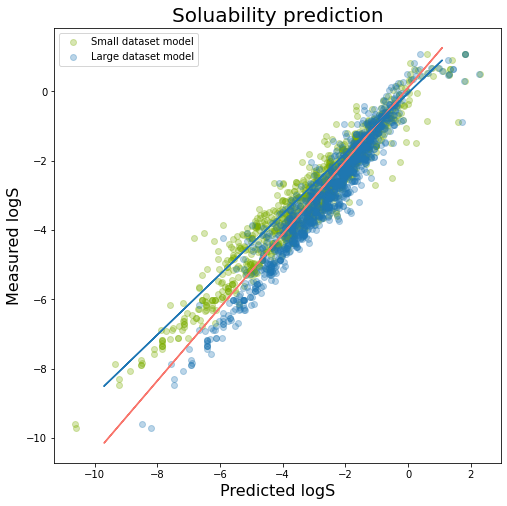

In [319]:
plt.figure(figsize=(8,8))
plt.scatter(x= logS_pred, y = logS_meas, c="#7CAE00", alpha=0.3, label = 'Small dataset model')
plt.scatter(x = logS_pred_large, y = logS_meas, alpha = 0.3, label = 'Large dataset model')

trend_line = np.polyfit(y_meas, y_pred, 1)
a = np.poly1d(trend_line)

trend_line_large = np.polyfit(logS_meas, logS_pred_large, 1)
a_1 = np.poly1d(trend_line_large)

plt.plot(y_meas, a(y_meas),"#F8766D")
plt.plot(y_meas, a_1(y_meas))
plt.xlabel('Predicted logS', size = 16)
plt.ylabel('Measured logS', size = 16)
plt.legend()
plt.title('Soluability prediction', size = 20)